In [0]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !nvidia-smi

  # mount google drive to colab
  from google.colab import drive
  drive.mount('/content/drive')

  # Install TensorFlow on Colab
  try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
  except Exception:
    pass

  PATH = 'drive/My Drive/Colab Notebooks/'
else:
  PATH = ''

Tue Feb  4 04:28:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
import tensorflow.keras.layers as layers
import time
import pickle

print(tf.__version__)

2.1.0


In [0]:
env = gym.make('Pong-v0')

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.float32)

In [0]:
def crop(img, size):
    x = (img.shape[0] - size[0]) // 2
    y = (img.shape[1] - size[1]) // 2
    return img[x:x+size[0], y:y+size[1]]
    

In [0]:
def process_img(img):
    img = rgb2gray(img)
    img = cv2.resize(img, (84, 110))
    img = crop(img, (84, 84))
    return img

In [0]:
class ExpBuffer(list):
    def __init__(self):
        super().__init__()
        self.capacity = 1e6

    def append(self, x):
        if len(self) >= self.capacity:
            self.pop(0)
        super().append(x)

In [0]:
def skip_frames(n):
    exp_stack = []
    for _ in range(n):
        exp_stack.append(env.step(0))
        # break if done
        if exp_stack[-1][2]:
            break
    return exp_stack

In [0]:
def one_hot_mse(predicted_y, target_y):
    one_hot = tf.one_hot(target_y[1], predicted_y.shape[-1])
    return tf.reduce(tf.square(one_hot * predicted_y - one_hot * target_y[0]))

Action space

0 | 1 | 2 | 3 | 4 | 5
--- | --- | --- | --- | --- | ---
Nothing | Nothing | Up | Down | Up | Down

In [0]:
# There are only 3 unique actions in the space
action_2_space = {0:0, 1:2, 2:3}

In [0]:
class T():
    s = 0
    a = 1
    r = 2
    s_next = 3
    terminal = 4

In [0]:
class E():
    s = 0
    r = 1
    done = 2
    info = 3

In [0]:
optimizer = tf.keras.optimizers.RMSprop()

model = tf.keras.models.Sequential([
    layers.Conv2D(16, 8, 4, activation='relu'),
    layers.Conv2D(32, 4, 2, activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(3)
])

In [0]:
def selective_mse(y_true, y_pred, actions):
    y_true = tf.cast(y_true, tf.dtypes.float32)
    actions = list(enumerate(actions))
    dif = y_true - tf.gather_nd(y_pred, actions)
    return tf.reduce_mean(tf.square(dif))

In [0]:
def step(model, exp_buffer, optimizer, batch_size=32):
    loss_value = 0
    if (len(exp_buffer) != 0):
        x_batch = []
        y_batch = []
        a_batch = []

        for _ in range(batch_size):
            i = np.random.randint(len(exp_buffer))
            x_batch.append(exp_buffer[i][T.s])
            a_batch.append(exp_buffer[i][T.a])
            if exp_buffer[i][T.terminal]:
                y_batch.append(exp_buffer[i][T.r])
            else:
                qmax = np.max(model(np.expand_dims(exp_buffer[i][T.s_next], 0)))
                y_batch.append(exp_buffer[i][T.r] + qmax)

        x_batch = tf.convert_to_tensor(x_batch)
        y_batch = tf.convert_to_tensor(y_batch)

        with tf.GradientTape() as t:
            y_pred = model(x_batch)
            loss_value = selective_mse(y_batch, y_pred, a_batch)
        grads = t.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss_value

In [0]:
# save variables in google drive
def save(num=1):
  training_variables = {'e': e, 'exp_buffer': exp_buffer, 'optimizer_weights': optimizer.weights, 
                        'num_updates': num_updates}
  with open(PATH + 'dqn-pong-model/training_variables.p', 'wb') as file:
    pickle.dump(training_variables, file)
  model.save_weights(PATH + 'dqn-pong-model/weights')
  if num % 2000 == 0:
    with open(PATH + 'dqn-pong-model/training_variables_bk.p', 'wb') as file:
      pickle.dump(training_variables, file)
    model.save_weights(PATH + 'dqn-pong-model/weights_bk')


In [0]:
'''
x_batch = []
y_batch = []
a_batch = []

for _ in range(32):
    i = np.random.randint(len(exp_buffer))
    x_batch.append(exp_buffer[i][T.s])
    a_batch.append(exp_buffer[i][T.a])
    if exp_buffer[i][T.terminal]:
        y_batch.append(exp_buffer[i][T.r])
    else:
        qmax = np.max(model(np.expand_dims(exp_buffer[i][T.s_next], 0)))
        y_batch.append(exp_buffer[i][T.r] + qmax)

start_time = time.time()
_ = tf.convert_to_tensor(x_batch)
_ = tf.convert_to_tensor(y_batch)
print('batching time: {}'.format(time.time() - start_time))
'''

"\nx_batch = []\ny_batch = []\na_batch = []\n\nfor _ in range(32):\n    i = np.random.randint(len(exp_buffer))\n    x_batch.append(exp_buffer[i][T.s])\n    a_batch.append(exp_buffer[i][T.a])\n    if exp_buffer[i][T.terminal]:\n        y_batch.append(exp_buffer[i][T.r])\n    else:\n        qmax = np.max(model(np.expand_dims(exp_buffer[i][T.s_next], 0)))\n        y_batch.append(exp_buffer[i][T.r] + qmax)\n\nstart_time = time.time()\n_ = tf.convert_to_tensor(x_batch)\n_ = tf.convert_to_tensor(y_batch)\nprint('batching time: {}'.format(time.time() - start_time))\n"

In [0]:
load = True
reset = False
episodes = 60
render = False

loss_log = []
if load:
  # load past variables
  model.load_weights(PATH + 'dqn-pong-model/weights')
  with open(PATH + 'dqn-pong-model/training_variables.p', 'rb') as file:
    training_variables = pickle.load(file)
  e = training_variables['e']
  exp_buffer = training_variables['exp_buffer']
  optimizer_weights = training_variables['optimizer_weights']
  num_updates = training_variables['num_updates']
if reset:
  exp_buffer = ExpBuffer()
  e = 1
  num_updates = 0

# one epoch corresponds to 50000 updates, aim for 100 epochs

In [0]:
'Epoch: {} / 100'.format(num_updates / 50000)

'Epoch: 0.84 / 100'

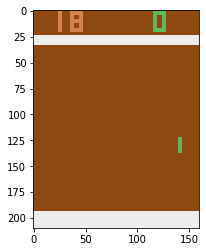

In [0]:
# training loop
for i_episode in range(episodes):
    start_time = time.time()
    for t in range(1500):
        # track the time spent computing one step
        if (t % 50 == 0 ):
          print(time.time() - start_time)
        start_time = time.time()

        # skip first 3 frames
        if t == 0:
            observation = env.reset()
            exp_stack = [[observation, 0, None, None]]
            exp_stack.extend(skip_frames(2))
        else:
            exp_stack = skip_frames(3)
        if exp_stack[-1][E.done]:
            break

        # agent choose action with annealing e greedy
        if t == 0 or np.random.random() < e:
            action = np.random.choice(list(action_2_space.keys()))
        else:
            q = model(np.expand_dims(exp_buffer[-1][T.s], 0))
            action = int(np.argmax(q, axis=1))
        e -= (1 - 0.1) / 1e6

        # update weights on past experience minibatch, size=32
        loss_log.append(step(model, exp_buffer, optimizer))
        num_updates += 1

        # stack frames into one state and add a new transition experience to experience buffer
        exp = env.step(action_2_space[action])
        exp_stack.append(exp)
        img_stack = np.stack([process_img(exp[0]) for exp in exp_stack], axis=2)
        reward = np.sum([exp[1] for exp in exp_stack])
        if t != 0:
            # s(t), a, r, s(t+1), terminal
            exp_buffer.append([last_img_stack, action, reward, img_stack, False])
        last_img_stack = img_stack

        # render gameplay
        if render:
          plt.imshow(env.render(mode='rgb_array'))
          display.display(plt.gcf())
          display.clear_output(wait=True)

        # checkpoint progress
        if num_updates % 1000 == 0:
          save(num_updates)

        if exp_stack[-1][E.done]:
            break
            
    # set last transition to be terminal
    if len(exp_stack) != 0:
        exp_buffer[-1][T.terminal] = True
    print('Episode {} finished after {} timesteps'.format(i_episode, t))

In [0]:
save()

In [0]:
img = exp_buffer[np.random.randint(len(exp_buffer))][0]
print(model(np.expand_dims(img, 0)))
plt.imshow(img[...,1], cmap='gray')

In [0]:
#env.close()